<a href="https://colab.research.google.com/github/DrVenkataRajeshKumar/OPG/blob/main/atmpt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

Using TensorFlow backend.


In [3]:
cd /content/drive/MyDrive/OPG

/content/drive/MyDrive/OPG


In [4]:
ls

 EVA4Library/   opg_utils.py     train.csv                     valid.csv
'gray scale'/   __pycache__/     train-small.csv               valid_new.csv
 LABELS/        resnetmodel.py   try/                          valid-small.csv
 modified/      rrr.jpg         "utf-8''densenet.hdf5"         valid.xlsx
'new labels'/   test.csv        "utf-8''pretrained_model.h5"
'opg t.xlsx'    test.xlsx        util.py


In [5]:
from opg_utils import get_mean_std_per_batch, load_image, grad_cam, compute_gradcam, get_roc_curve, check_for_leakage, compute_class_freqs, get_weighted_loss, get_train_generator, get_test_and_valid_generator

In [6]:
import pandas as pd

train_df = pd.read_csv("train.csv")
valid_df = pd.read_csv("valid_new.csv")

test_df = pd.read_csv("test.csv")

test_df.head()

,Image name,ID,IMPACTION,FRACTURE,CYSTS,TUMOURS,SUPERNEUMERARY,CARIES,Partially Edentulous,Completly Edentulous,IMPLANTS,CGP,Agg Perio,Filling,RCT,crown/bridge,clips,Mixed Dentition,ROOT STUMPS,periapical abcess
0,s mounika lakshmi. 321225 20180630 12-12-52.jp...,321225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,s murali krishna 397890 20180423 12-46-31.jpg,397890,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,s n radha rani 385058 20180104 12-54-30.jpg,385058,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
3,S NAGA MANI 385062 20180104 16-01-34.jpg,385062,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0
4,s naga mani 404836 20180620 12-43-16.jpg,404836,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0


In [7]:
         # 'FRACTURE', 
         # 'CYSTS', 
         # 'TUMOURS', 
         # 'SUPERNEUMERARY',
          #          'IMPLANTS', 
           #                   'Agg Perio',

In [8]:
labels = ['IMPACTION', 
          'CARIES', 
          'Partially Edentulous', 
          'Agg Perio',
          'FRACTURE', 
          'SUPERNEUMERARY', 
          'Filling',
          'CGP', 
          'RCT', 
          'crown/bridge', 
          'clips',
          'Mixed Dentition',
          'ROOT STUMPS', 
          'periapical abcess']
	

In [9]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'ID')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'ID')))

leakage between train and test: False
leakage between valid and test: True


In [10]:
IMAGE_DIR = 'gray scale'
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image name", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image name", labels)

getting train generator...


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 27 invalid image filename(s) in x_col="Image name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 715 validated image filenames.
getting train and valid generators...
Found 715 validated image filenames.
Found 214 validated image filenames.
Found 213 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 6 invalid image filename(s) in x_col="Image name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


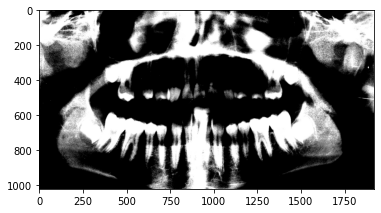

In [11]:
import cv2

x, y = train_generator.__getitem__(0)
#plt.imshow(x[0]);
plt.imshow((x[0]),cmap=plt.cm.gray)



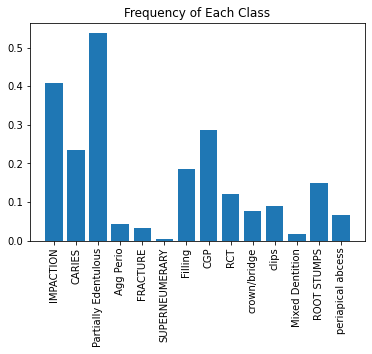

In [12]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [13]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos, freq_neg

(array([0.40979021, 0.23496503, 0.53706294, 0.04195804, 0.03356643,
        0.0027972 , 0.18461538, 0.28671329, 0.12167832, 0.07692308,
        0.08951049, 0.01818182, 0.14825175, 0.06713287]),
 array([0.59020979, 0.76503497, 0.46293706, 0.95804196, 0.96643357,
        0.9972028 , 0.81538462, 0.71328671, 0.87832168, 0.92307692,
        0.91048951, 0.98181818, 0.85174825, 0.93286713]))

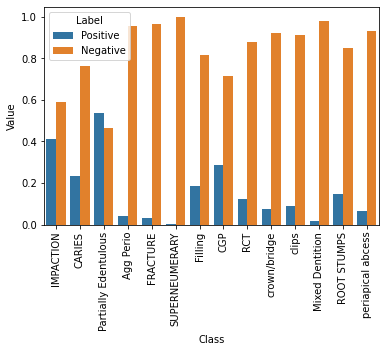

In [14]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [15]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

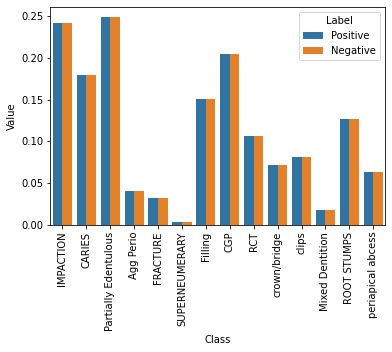

In [16]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [19]:

# create the base pre-trained model
base_model = DenseNet121(weights="utf-8''densenet.hdf5", include_top=False)

x = base_model.output

# add a global spatial average pooling layer0
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='SGD', loss=get_weighted_loss(pos_weights, neg_weights))

#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=int(len(train_loader))+1, epochs=EPOCHS,  pct_start=0.2, div_factor=10, final_div_factor=100 )


In [ ]:
history = model.fit(train_generator, 
                    validation_data=valid_generator,
                    steps_per_epoch=100, 
                    validation_steps=25, 
                    epochs = 30)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()


Epoch 1/30
100/100 [==============================] - 88s 877ms/step - loss: 2.6411 - val_loss: 3.9379
Epoch 2/30
 37/100 [==========>...................] - ETA: 31s - loss: 2.1658

In [ ]:
#model.load_weights("utf-8''pretrained_model.h5")

In [ ]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))

In [ ]:
#tf.compat.v1.disable_eager_execution()

Error in generating ROC curve for SUPERNEUMERARY. Dataset lacks enough examples.
Error in generating ROC curve for Mixed Dentition. Dataset lacks enough examples.


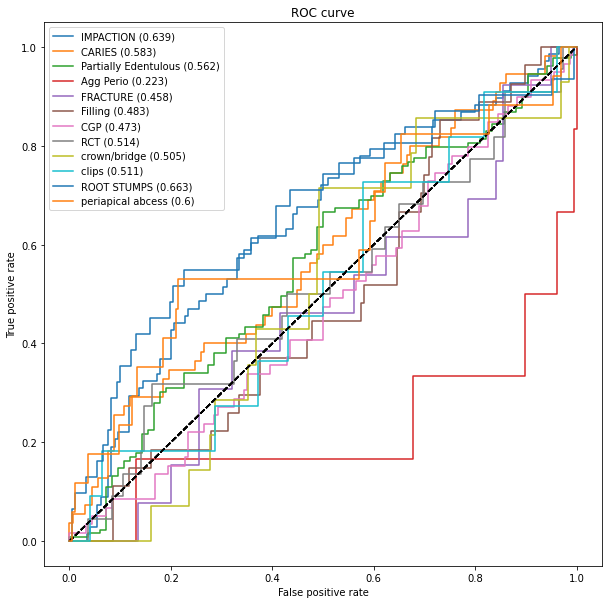

In [ ]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

In [ ]:
df = pd.read_csv("test.csv")
IMAGE_DIR = "modified/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::3])[:9]

NameError: ignored

In [ ]:
compute_gradcam(model, "s r s lakshmi 378345 20180313 10-51-00.jpg", IMAGE_DIR, df, labels, labels_to_show)

NameError: ignored

Loading original image
Generating gradcam for class IMPACTION
Generating gradcam for class Agg Perio


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


Generating gradcam for class CGP
Generating gradcam for class crown/bridge


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


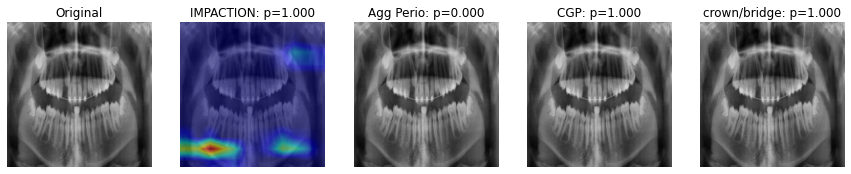

In [ ]:

compute_gradcam(model, "s rajeev 415621 20180910 12-13-51.jpg", IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class IMPACTION
Generating gradcam for class Agg Perio


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


Generating gradcam for class CGP
Generating gradcam for class crown/bridge


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


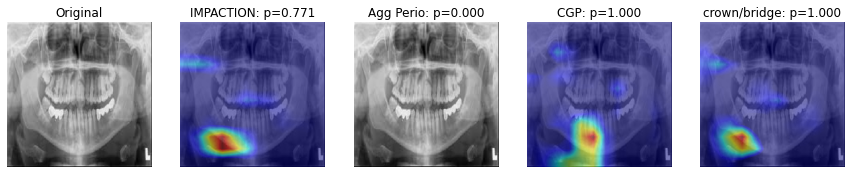

In [ ]:
compute_gradcam(model, "r11.jpg", IMAGE_DIR, df, labels, labels_to_show)

In [ ]:
train_results = pd.read_csv("train_preds.csv")
valid_results = pd.read_csv("valid_preds.csv")

# the labels in our dataset
class_labels = ['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation']

# the labels for prediction values in our dataset
pred_labels = [l + "_pred" for l in class_labels]

In [ ]:
y = valid_results[class_labels].values
pred = valid_results[pred_labels].values

In [ ]:
# let's take a peek at our dataset
valid_results[np.concatenate([class_labels, pred_labels])].head()

In [ ]:
plt.xticks(rotation=90)
plt.bar(x = class_labels, height= y.sum(axis=0));

In [ ]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def true_positives(y, pred, th=0.5):
    """
    Count true positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TP (int): true positives
    """
    TP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    # compute TP
    TP = np.sum((y == 1) & (thresholded_preds == 1))
    
    return TP

def true_negatives(y, pred, th=0.5):
    """
    Count true negatives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TN (int): true negatives
    """
    TN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute TN
    TN = np.sum((y == 0) & (thresholded_preds == 0))
    
    ### END CODE HERE ###
    
    return TN

def false_positives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FP (int): false positives
    """
    FP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # compute FP
    FP = np.sum((y == 0) & (thresholded_preds == 1))
    
    ### END CODE HERE ###
    
    return FP

def false_negatives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FN (int): false negatives
    """
    FN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute FN
    FN = np.sum((y == 1) & (thresholded_preds == 0))
    
    ### END CODE HERE ###
    
    return FN

In [ ]:
# Note: we must explicity import 'display' in order for the autograder to compile the submitted code
# Even though we could use this function without importing it, keep this import in order to allow the grader to work
from IPython.display import display
# Test
df = pd.DataFrame({'y_test': [1,1,0,0,0,0,0,0,0,1,1,1,1,1],
                   'preds_test': [0.8,0.7,0.4,0.3,0.2,0.5,0.6,0.7,0.8,0.1,0.2,0.3,0.4,0],
                   'category': ['TP','TP','TN','TN','TN','FP','FP','FP','FP','FN','FN','FN','FN','FN']
                  })

display(df)
#y_test = np.array([1, 0, 0, 1, 1])
y_test = df['y_test']

#preds_test = np.array([0.8, 0.8, 0.4, 0.6, 0.3])
preds_test = df['preds_test']

threshold = 0.5
print(f"threshold: {threshold}\n")

print(f"""Our functions calculated: 
TP: {true_positives(y_test, preds_test, threshold)}
TN: {true_negatives(y_test, preds_test, threshold)}
FP: {false_positives(y_test, preds_test, threshold)}
FN: {false_negatives(y_test, preds_test, threshold)}
""")

print("Expected results")
print(f"There are {sum(df['category'] == 'TP')} TP")
print(f"There are {sum(df['category'] == 'TN')} TN")
print(f"There are {sum(df['category'] == 'FP')} FP")
print(f"There are {sum(df['category'] == 'FN')} FN")

In [ ]:
util.get_performance_metrics(y, pred, class_labels)

In [ ]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_accuracy(y, pred, th=0.5):
    """
    Compute accuracy of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        accuracy (float): accuracy of predictions at threshold
    """
    accuracy = 0.0
    thresholded_preds = pred >= th
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP, FP, TN, FN using our previously defined functions
    TP = true_positives(y, pred, th)
    FP = false_positives(y, pred, th)
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y, pred, th)

    # Compute accuracy using TP, FP, TN, FN
    accuracy = (TP+TN)/(TP+FP+TN+FN)
    
    ### END CODE HERE ###
    
    return accuracy

In [ ]:
# Test
print("Test case:")

y_test = np.array([1, 0, 0, 1, 1])
print('test labels: {y_test}')

preds_test = np.array([0.8, 0.8, 0.4, 0.6, 0.3])
print(f'test predictions: {preds_test}')

threshold = 0.5
print(f"threshold: {threshold}")

print(f"computed accuracy: {get_accuracy(y_test, preds_test, threshold)}")

In [ ]:
util.get_performance_metrics(y, pred, class_labels, acc=get_accuracy)

In [ ]:
get_accuracy(valid_results["Emphysema"].values, np.zeros(len(valid_results)))

In [ ]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_prevalence(y):
    """
    Compute prevalence.

    Args:
        y (np.array): ground truth, size (n_examples)
    Returns:
        prevalence (float): prevalence of positive cases
    """
    prevalence = 0.0
    
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    prevalence = np.mean(y==1)
    
    ### END CODE HERE ###
    
    return prevalence

In [ ]:
# Test
print("Test case:\n")

y_test = np.array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1])
print(f'test labels: {y_test}')

print(f"computed prevalence: {get_prevalence(y_test)}")

In [ ]:
util.get_performance_metrics(y, pred, class_labels, acc=get_accuracy, prevalence=get_prevalence)

In [ ]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_sensitivity(y, pred, th=0.5):
    """
    Compute sensitivity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        sensitivity (float): probability that our test outputs positive given that the case is actually positive
    """
    sensitivity = 0.0
    thresholded_preds = pred >= th
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP and FN using our previously defined functions
    
    TP = true_positives(y, pred, th)
    FN = false_negatives(y, pred, th)

    # use TP and FN to compute sensitivity
    sensitivity = TP/(TP+FN)
    
    ### END CODE HERE ###
    
    return sensitivity

def get_specificity(y, pred, th=0.5):
    """
    Compute specificity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        specificity (float): probability that the test outputs negative given that the case is actually negative
    """
    specificity = 0.0
    thresholded_preds = pred >= th
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TN and FP using our previously defined functions

    FP = false_positives(y, pred, th)
    TN = true_negatives(y, pred, th)

    
    # use TN and FP to compute specificity 
    specificity = TN/(TN+FP)
    
    ### END CODE HERE ###
    
    return specificity

In [ ]:
util.get_performance_metrics(y, pred, class_labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity)

In [ ]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_ppv(y, pred, th=0.5):
    """
    Compute PPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        PPV (float): positive predictive value of predictions at threshold
    """
    PPV = 0.0
    thresholded_preds = pred >= th
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP and FP using our previously defined functions

    TP = true_positives(y, pred, th)
    FP = false_positives(y, pred, th)


    # use TP and FP to compute PPV
    PPV = TP/(TP+FP)
    
    ### END CODE HERE ###
    
    return PPV

def get_npv(y, pred, th=0.5):
    """
    Compute NPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        NPV (float): negative predictive value of predictions at threshold
    """
    NPV = 0.0
    thresholded_preds = pred >= th
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TN and FN using our previously defined functions

    TN = true_negatives(y, pred, th)
    FN = false_negatives(y, pred, th)

    # use TN and FN to compute NPV
    NPV = TN/(TN+FN)
    
    ### END CODE HERE ###
    
    return NPV

In [ ]:
util.get_performance_metrics(y, pred, class_labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv)

In [ ]:
util.get_curve(y, pred, class_labels)

In [ ]:
from sklearn.metrics import roc_auc_score
util.get_performance_metrics(y, pred, class_labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score)

In [ ]:
def bootstrap_auc(y, pred, classes, bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))

    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = roc_auc_score(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

statistics = bootstrap_auc(y, pred, class_labels)

In [ ]:
util.print_confidence_intervals(class_labels, statistics)

In [ ]:
util.get_curve(y, pred, class_labels, curve='prc')

In [ ]:
from sklearn.metrics import f1_score
util.get_performance_metrics(y, pred, class_labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve(y, pred):
    plt.figure(figsize=(20, 20))
    for i in range(len(class_labels)):
        plt.subplot(4, 4, i + 1)
        fraction_of_positives, mean_predicted_value = calibration_curve(y[:,i], pred[:,i], n_bins=20)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
        plt.xlabel("Predicted Value")
        plt.ylabel("Fraction of Positives")
        plt.title(class_labels[i])
    plt.tight_layout()
    plt.show()

In [ ]:
plot_calibration_curve(y, pred)

In [ ]:
from sklearn.linear_model import LogisticRegression as LR 

y_train = train_results[class_labels].values
pred_train = train_results[pred_labels].values
pred_calibrated = np.zeros_like(pred)

for i in range(len(class_labels)):
    lr = LR(solver='liblinear', max_iter=10000)
    lr.fit(pred_train[:, i].reshape(-1, 1), y_train[:, i])    
    pred_calibrated[:, i] = lr.predict_proba(pred[:, i].reshape(-1, 1))[:,1]

In [ ]:
plot_calibration_curve(y[:,], pred_calibrated)